<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/ConvNet_ResNet18_BESTPARAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
mlruns	Test.pkl  Train_labels.csv  Train.pkl


In [ ]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

/content/drive/MyDrive/imageunderstanding
ExampleSubmissionRandom.csv  Test.pkl	       VAL_ACCU_RES18.csv
Load_data.ipynb		     Train_labels.csv  VAL_ACCU_RES34_ROTATE.csv
PRED_RESULT.csv		     Train.pkl


In [3]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"
CSV_OUTPUT_PATH = "PRED_RESULT.csv"

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Dataset Class / Data Loaders

In [7]:
IMG_SIZE = (224, 224)

In [8]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE),
    # transforms.RandomRotation(10)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [9]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [10]:
BATCH_SIZE = 128
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [11]:
VAL_SPLIT = 0.15
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Test Dataset / Loader

In [23]:
class MyTestSet(Dataset):
  def __init__(self, img_file, transform=None):
    self.data = pickle.load( open(img_file, 'rb' ), encoding='bytes')
    self.transform = transform

  def __len__(self):
    # return self.data.shape[0]
    return len(self.data)

  def __getitem__(self, index):
    img = self.data[index].squeeze()
    img = Image.fromarray((img*255).astype('uint8'), mode='L')
    if self.transform is not None:
      img = self.transform(img)
    return img

In [24]:
test_dataset = MyTestSet(TEST_DATA_PATH,transform=img_transform)
# dataloader for test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## ResNet18

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision.models as models

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

### alexnet

In [ ]:
# model = models.alexnet(pretrained=False)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# model.classifier[6] = nn.Linear(4096, 10)
# model = model.to(DEVICE)

### resnet18

In [13]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### resnet34

In [ ]:
model = models.resnet34(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### optimizer & initialization

In [17]:
# optimizer = optim.SGD(tutor_model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(tutor_model.parameters(), lr=1, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.RMSprop(model.parameters())

train_losses = []
train_counter = []
val_accus = []
epochs = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(3)]

### Train and test function, used many times

In [18]:
def train(epoch, model, loader):
  model.train()
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    # print(data.shape)
    target = target.to(DEVICE)
    output = model(data)
    # print(output.shape)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    loss = F.cross_entropy(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 200 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(loader.dataset),
        100. * batch_idx / len(loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
      torch.save(model.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def val(model, loader):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = model(data)
      val_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(loader.dataset)
  val_losses.append(val_loss)

  val_accu = 100. * correct / len(loader.dataset)
  val_accus.append(val_accu)
  epochs.append(epoch)

  print('Val set: Epoch: {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    epoch, val_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))

Train the network

In [ ]:
for epoch in range(1, 41):
  train(epoch, model, train_loader)
  val(model, val_loader)

Train Epoch: 1 [0/51000 (0%)]	Loss: 2.314001
Train Epoch: 1 [25600/51000 (50%)]	Loss: 0.282228


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 0.2528, Accuracy: 8269/9000 (91.88%)
Train Epoch: 2 [0/51000 (0%)]	Loss: 0.163115
Train Epoch: 2 [25600/51000 (50%)]	Loss: 0.101653
Val set: Epoch: 2, Avg. loss: 0.2248, Accuracy: 8349/9000 (92.77%)
Train Epoch: 3 [0/51000 (0%)]	Loss: 0.073130
Train Epoch: 3 [25600/51000 (50%)]	Loss: 0.089627
Val set: Epoch: 3, Avg. loss: 0.4656, Accuracy: 7761/9000 (86.23%)
Train Epoch: 4 [0/51000 (0%)]	Loss: 0.032773
Train Epoch: 4 [25600/51000 (50%)]	Loss: 0.024779
Val set: Epoch: 4, Avg. loss: 0.1500, Accuracy: 8604/9000 (95.60%)
Train Epoch: 5 [0/51000 (0%)]	Loss: 0.007777
Train Epoch: 5 [25600/51000 (50%)]	Loss: 0.023209
Val set: Epoch: 5, Avg. loss: 0.1454, Accuracy: 8606/9000 (95.62%)
Train Epoch: 6 [0/51000 (0%)]	Loss: 0.028757
Train Epoch: 6 [25600/51000 (50%)]	Loss: 0.022861
Val set: Epoch: 6, Avg. loss: 0.1995, Accuracy: 8489/9000 (94.32%)
Train Epoch: 7 [0/51000 (0%)]	Loss: 0.023866
Train Epoch: 7 [25600/51000 (50%)]	Loss: 0.017611
Val set: Epoch: 7, Avg. loss

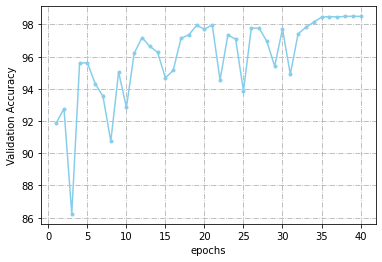

In [ ]:
fig = plt.figure()
plt.plot(epochs, val_accus, color='skyblue',marker='.')
# plt.legend(['Validation Accuracy'], loc='lower right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy')
plt.grid(linestyle='-.')

In [ ]:
# convert val_accus (tensor) to list, for plotting
accu_list = []
for accu in val_accus:
  accu_list.append(accu.item())

df = pd.DataFrame(accu_list) 
df.to_csv('VAL_ACCU_RES18.csv')

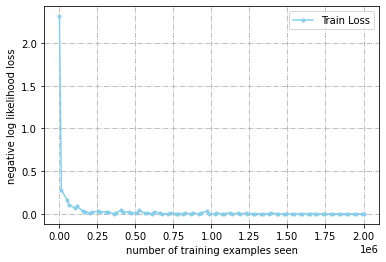

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='skyblue',marker='.')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.grid(linestyle='-.')

## Train on ALL data

In [19]:
full_model = models.resnet18(pretrained=False)
full_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
full_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
full_model = full_model.to(DEVICE)
# optimizer = optim.RMSprop(full_model.parameters())
# this is the best optimizer for resnet18
optimizer = optim.Adam(full_model.parameters(), lr=0.0001)

In [20]:
for epoch in range(1, 40):
  train(epoch, full_model, data_loader)
  val(full_model, val_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382847
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.218722
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.250253


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 0.2980, Accuracy: 8151/9000 (90.57%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.094088
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.168339
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.102162
Val set: Epoch: 2, Avg. loss: 0.2380, Accuracy: 8271/9000 (91.90%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.119166
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.035711
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.105084
Val set: Epoch: 3, Avg. loss: 0.1107, Accuracy: 8658/9000 (96.20%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.041760
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.028242
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.036926
Val set: Epoch: 4, Avg. loss: 0.2441, Accuracy: 8279/9000 (91.99%)
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.028352
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.027135
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.018805
Val set: Epoch: 5, Avg. loss: 0.3822, Accuracy: 7962/9000 (88.47%)
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.009294
Train Epoch: 6 [25600/60000 (43%)]	Loss:

## Make predictions on test data

In [25]:
def predict(model):
  pred_test = []
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      data = data.to(DEVICE)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      for x in pred:
        pred_test.append(x.item())
  return pred_test

In [26]:
pred_test = predict(full_model)
print(len(pred_test))
df_pred_test = pd.DataFrame({'id': range(10000), 'class': pred_test})
df_pred_test.to_csv(CSV_OUTPUT_PATH, index=False)

10000


## Manually check prediction results

torch.Size([128, 1, 224, 224])
torch.Size([128, 224, 224])


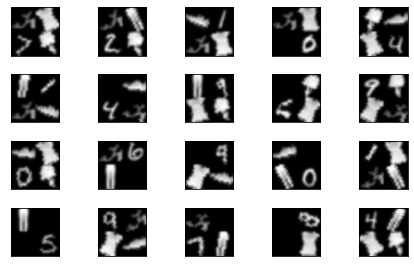

In [27]:
# Read many TEST data and display them, compare with our prediction in CSV
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
imgs = (next(iter(test_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.xticks([])
  plt.yticks([])